<a href="https://colab.research.google.com/github/OscPop/langchain-experiments/blob/main/Chat_with_PDFs_Custom_Knowledge_ChatGPT_with_LangChain.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Custom Knowledge ChatGPT with LangChain - Chat with PDFs**

**By Liam Ottley:**  [YouTube](https://youtube.com/@LiamOttley)





0.   Installs, Imports and API Keys
1.   Loading PDFs and chunking with LangChain
2.   Embedding text and storing embeddings
3.   Creating retrieval function
4.   Creating chatbot with chat memory (OPTIONAL) 








# 0. Installs, Imports and API Keys

In [1]:
# RUN THIS CELL FIRST!
!pip install -q langchain==0.0.150 pypdf pandas matplotlib tiktoken textract transformers openai faiss-cpu

  DEPRECATION: docx2txt is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  DEPRECATION: compressed-rtf is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be found at https://github.com/pypa/pip/issues/8559
  DEPRECATION: olefile is being installed using the legacy 'setup.py install' method, because it does not have a 'pyproject.toml' and the 'wheel' package is not installed. pip 23.1 will enforce this behaviour change. A possible replacement is to enable the '--use-pep517' option. Discussion can be 

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from transformers import GPT2TokenizerFast
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain.embeddings import OpenAIEmbeddings
from langchain.vectorstores import FAISS
from langchain.chains.question_answering import load_qa_chain
from langchain.llms import OpenAI
from langchain.chains import ConversationalRetrievalChain

/Users/oscarpopplarsen/langchain-experiments/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
None of PyTorch, TensorFlow >= 2.0, or Flax have been found. Models won't be available and only tokenizers, configuration and file/data utilities can be used.


In [3]:
load_dotenv()

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY")

# 1. Loading PDFs and chunking with LangChain

In [ ]:
# You MUST add your PDF to local files in this notebook (folder icon on left hand side of screen)

# Simple method - Split by pages 
loader = PyPDFLoader("")
pages = loader.load_and_split()
print(pages[0])

# SKIP TO STEP 2 IF YOU'RE USING THIS METHOD
chunks = pages

In [4]:
# Advanced method - Split by chunk
"""
# Step 1: Convert PDF to text
import textract
doc = textract.process("./attention_is_all_you_need.pdf")

# Step 2: Save to .txt and reopen (helps prevent issues)
with open('attention_is_all_you_need.txt', 'w') as f:
    f.write(doc.decode('utf-8'))
"""
with open('./Data/Rapporter 2023/2023_6.txt', 'r') as f:
    text = f.read()

# Step 3: Create function to count tokens
tokenizer = GPT2TokenizerFast.from_pretrained("gpt2")

def count_tokens(text: str) -> int:
    return len(tokenizer.encode(text))

# Step 4: Split text into chunks
text_splitter = RecursiveCharacterTextSplitter(
    # Set a really small chunk size, just to show.
    chunk_size = 512,
    chunk_overlap  = 24,
    length_function = count_tokens,
)

chunks = text_splitter.create_documents([text])

Token indices sequence length is longer than the specified maximum sequence length for this model (1112 > 1024). Running this sequence through the model will result in indexing errors


In [5]:
# Result is many LangChain 'Documents' around 500 tokens or less (Recursive splitter sometimes allows more tokens to retain context)
type(chunks[0]) 

langchain.schema.Document

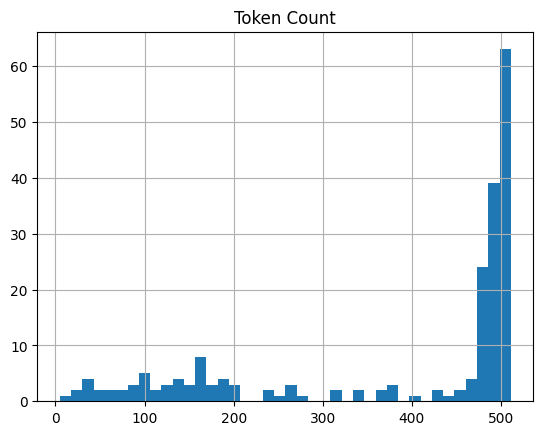

In [6]:
# Quick data visualization to ensure chunking was successful

# Create a list of token counts
token_counts = [count_tokens(chunk.page_content) for chunk in chunks]

# Create a DataFrame from the token counts
df = pd.DataFrame({'Token Count': token_counts})

# Create a histogram of the token count distribution
df.hist(bins=40, )

# Show the plot
plt.show()

# 2. Embed text and store embeddings

In [7]:
# Get embedding model
embeddings = OpenAIEmbeddings()

# Create vector database
db = FAISS.from_documents(chunks, embeddings)

# 3. Setup retrieval function

In [8]:
# Check similarity search is working
query = "Vad handlar texten om?"
docs = db.similarity_search(query)
docs[0]

Document(page_content='svenska.68 Det är dock inte tydligt hur långt det här kravet sträcker sig.  \n \n65   Det har funnits stor försiktighet kring att ta fram språkstatistik i Sverige, med hänvisning till \nden personliga integriteten.  \n66   Bl.a. Polismyndigheten, Utvärdering av e-tjänster, 2021; CSN, Kundernas upplevelse av ansökan \nom studiemedel, 2022. \n67   10–12 §§. \n68   13 §.', metadata={})

In [11]:
# Create QA chain to integrate similarity search with user queries (answer query from knowledge base)

chain = load_qa_chain(OpenAI(temperature=0), chain_type="stuff")

query = "Vad handlar texten om?"
docs = db.similarity_search(query)

chain.run(input_documents=docs, question=query)

' Texten handlar om användbarhet och interaktivitet för digitala tjänster som får anses vara grundläggande, såsom Skatteverkets digitala deklarationstjänst, anmäla ny adress eller skriva in sig hos Arbetsförmedlingen.'

# 5. Create chatbot with chat memory (OPTIONAL) 

In [13]:
from IPython.display import display
import ipywidgets as widgets

# Create conversation chain that uses our vectordb as retriver, this also allows for chat history management
qa = ConversationalRetrievalChain.from_llm(OpenAI(temperature=0.1), db.as_retriever())

In [14]:
chat_history = []

def on_submit(_):
    query = input_box.value
    input_box.value = ""
    
    if query.lower() == 'exit':
        print("Thank you for using the State of the Union chatbot!")
        return
    
    result = qa({"question": query, "chat_history": chat_history})
    chat_history.append((query, result['answer']))
    
    display(widgets.HTML(f'<b>User:</b> {query}'))
    display(widgets.HTML(f'<b><font color="blue">Chatbot:</font></b> {result["answer"]}'))

print("Welcome to the Transformers chatbot! Type 'exit' to stop.")

input_box = widgets.Text(placeholder='Please enter your question:')
input_box.on_submit(on_submit)

display(input_box)

Welcome to the Transformers chatbot! Type 'exit' to stop.


/var/folders/pn/h0v_s94x231gxb7bq6h6wtpm0000gn/T/ipykernel_12756/3970211031.py:20: DeprecationWarning: on_submit is deprecated. Instead, set the .continuous_update attribute to False and observe the value changing with: mywidget.observe(callback, 'value').
  input_box.on_submit(on_submit)


Text(value='', placeholder='Please enter your question:')

HTML(value='<b>User:</b> Vem skrev rapporten?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Projektgruppen bestående av Linnea Sandell (projektleda…

HTML(value='<b>User:</b> Och vem var riksrevisor?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Helena Lindberg')

HTML(value='<b>User:</b> Vad var diarienumret?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  I don\'t know.')

HTML(value='<b>User:</b> Vilket diarienummer har dokumentet?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  2021:2731')

HTML(value='<b>User:</b> Vilket år skrevs rapporten=?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  I don\'t know.')

HTML(value='<b>User:</b> Vad var riksrevisionens rekommendationer?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Riksrevisionen rekommenderade regeringen att intensifie…

HTML(value='<b>User:</b> Vad var det för enkät som skickades ut?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Enkäten som skickades ut till panelen Rivkraft.')

HTML(value='<b>User:</b> vad är rivkraft?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Rivkraft är ett uppföljningssystem av levnadsvillkor fö…

HTML(value='<b>User:</b> Hur många svarade på enkäten?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  2 005 personer svarade på Rivkrafts webbenkät.')

HTML(value='<b>User:</b> Vad kom man fram till med enkäten?')

HTML(value='<b><font color="blue">Chatbot:</font></b>  Av de 2 782 personer som ingår i Rivkraftpanelen och so…